## 객실 사용 여부 관련 데이터
1. 데이터를 탐색하고 시각화(EDA)
2. 결측치를 탐색하고 대체 
3. 데이터의 불균형을 시각화
4. 데이터 오버샘플링
    - 원데이터를 , 랜덤오버샘플링과 , SMOTE의 3개의 데이터 셋 구성
5. 랜덤포레스트 분류분석으로 3개의 데이터셋의 정확도와 속도 측면으로 어떠한가 확인

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# 그래프에서 한글 깨짐 방지
import platform
if platform.system() == "Darwin":          # MAC인 경우
    plt.rc('font', family ="AppleGothic")
else:
    plt.rc('font',family='Malgun Gothic')



# warning메시지 무시
import warnings
warnings.filterwarnings('ignore')


In [21]:
hotel=pd.read_csv('../datasets/hotel_bookings.csv')
hotel.head()

,is_canceled,deposit_type,lead_time,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr
0,0,No Deposit,105.0,2,5,NaN,0,0,1,0,131.50
1,0,No Deposit,303.0,2,2,NaN,0,0,0,0,73.95
2,0,No Deposit,33.0,2,3,0.0,0,0,0,0,NaN
3,0,No Deposit,48.0,0,1,0.0,0,0,1,0,80.30
4,0,No Deposit,216.0,4,7,0.0,0,0,2,0,60.90


In [22]:
## 결측치 확인
hotel.isna().sum()

is_canceled                          0
deposit_type                         0
lead_time                            5
stays_in_weekend_nights              0
stays_in_week_nights                 0
is_repeated_guest                  358
previous_cancellations               0
previous_bookings_not_canceled       0
booking_changes                      0
days_in_waiting_list                 0
adr                               1063
dtype: int64

In [23]:
## 데이터의 타입
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     20000 non-null  int64  
 1   deposit_type                    20000 non-null  object 
 2   lead_time                       19995 non-null  float64
 3   stays_in_weekend_nights         20000 non-null  int64  
 4   stays_in_week_nights            20000 non-null  int64  
 5   is_repeated_guest               19642 non-null  float64
 6   previous_cancellations          20000 non-null  int64  
 7   previous_bookings_not_canceled  20000 non-null  int64  
 8   booking_changes                 20000 non-null  int64  
 9   days_in_waiting_list            20000 non-null  int64  
 10  adr                             18937 non-null  float64
dtypes: float64(3), int64(7), object(1)
memory usage: 1.7+ MB


In [24]:
## 종속 변수 특징 파악
hotel.deposit_type.describe()
## hotel.deposit_type.describe()는 hotel 데이터프레임의 deposit_type 열에 대한 기술 통계를 요약하여 반환하는 메서드입니다.
## hotel 데이터프레임에서 deposit_type 열을 선택합니다.
## 선택한 열에 대해 describe() 메서드를 호출합니다.
## describe() 메서드는 열의 기술 통계를 계산하고, 이를 요약하여 반환합니다.

count          20000
unique             3
top       No Deposit
freq           19138
Name: deposit_type, dtype: object

In [25]:
hotel.groupby(hotel['deposit_type']).mean()['adr']

deposit_type
No Deposit    101.965190
Non Refund     89.689476
Refundable     67.456154
Name: adr, dtype: float64

- 결측치의 존재 여부
    - 결측치가 존재하는 변수는 3개
    - 결측치의 총 개수는 1426개
    - 결측치가 존쟇는 변수들은 비율과 분로에 따라 각각 다른 결측치 대체 방식 사용
- 데이터 타입
    - 종속 변수 int
    - 독립 변수 object, int, float
    - object 타입은 인코딩을 통하여 변환
- 종속 변수 특징
    - object형
    - 변수는 20000개 중에 19138개의 관측치가 No Deposit이다

In [26]:
## 결측치의 비율 확인
print('lead time 결측치 비율: {}%'.format(round(5 /len(hotel)*100, 2)))
print('is repeated guest 결측치 비율: {}%'.format(round(358/len(hotel)*100, 2)))
print('adr 결측치 비율: {}%'.format(round(1063 /len(hotel)*100, 2)))

lead time 결측치 비율: 0.03%
is repeated guest 결측치 비율: 1.79%
adr 결측치 비율: 5.32%


- load_time 변수는 결측치가 1% 미만이므로, 결측치가 있는 행을 삭제
- is_repeated_guest 변수의 결측치는 최빈값으로 대체
- adr 변수의 결측치는 deposit_type별 평균으로 adr 대체

In [27]:
## is_repeated_guest 컬름의 최빈값
hotel['is_repeated_guest'].value_counts()

is_repeated_guest
0.0    18893
1.0      749
Name: count, dtype: int64

In [28]:
hotel_nonull=hotel

## lead_time 컬럼의 결측치 제거
hotel_nonull.dropna(subset=['lead_time'],axis=0, inplace=True)

## is_repeated_guest 컬럼은 최빈값(0)으로 대체
hotel_nonull['is_repeated_guest'].fillna(0)

## adr 변수는 연속평 변수이기 때문에 평균대치법 사용
## 보증금 유형에 따라 adr이 다르기 때문에 그룹별 평균의 값들 대체
fill_mean_func= lambda g: g.fillna(g.mean())
hotel_nonull =hotel_nonull.groupby('deposit_type').apply(fill_mean_func)

hotel_nonull.isna().sum()

is_canceled                       0
lead_time                         0
stays_in_weekend_nights           0
stays_in_week_nights              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
booking_changes                   0
days_in_waiting_list              0
adr                               0
dtype: int64

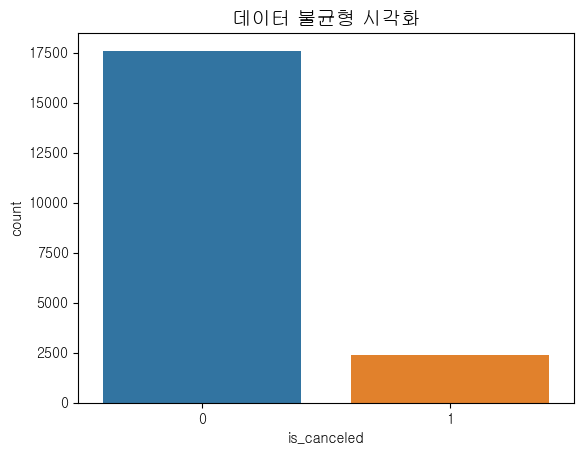

0 비율: 88.0%
1 비율: 12.0%


In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path ='C:/Windows/Fonts/NGULIM.TTF'
font = font_manager.FontProperties(fname =font_path).get_name()
rc('font', family =font)

sns.countplot(x='is_canceled', data =hotel_nonull)
plt.title('데이터 불균형 시각화', fontsize =14)
plt.show()
ratio0 = round(len(hotel_nonull[hotel_nonull['is_canceled']==0])/len(hotel_nonull)*100, 2)
ratio1 = round(len(hotel_nonull[hotel_nonull['is_canceled']==1])/len(hotel_nonull)*100, 2)
print('0 비율: {}%'.format(ratio0))
print('1 비율: {}%'.format(ratio1))

In [31]:
# 먼저 hotel_null 데이터의 object 형태 변수를 one_hot_encoding함
hotel_nonull= pd.get_dummies(hotel_nonull)

In [38]:
## 원본 데이터
from imblearn.over_sampling import RandomOverSampler, SMOTE
import time
# 원본 데이터 (hotel_nonull)
X = hotel_nonull[hotel_nonull.columns.difference(['is_canceled'])]
#print(X.shape)
## hotel_nonull 데이터프레임의 열 이름에서 'is_canceled'을 제외한 모든 열 이름을 반환합니다
y = hotel_nonull['is_canceled']


In [42]:
# Random Oversampling

start = time.time() # 시작 시간 저장
ros = RandomOverSampler(random_state =42)
X_ro, y_ro = ros.fit_resample(X, y)
print('time :', time.time() - start) # 현재시각 - 시작시간 = 실행 시간
print(X_ro.shape)

time : 0.013063907623291016
(35190, 9)


In [41]:
# SMOTE

start = time.time() # 시작 시간 저장
sm = SMOTE(random_state =42)
X_sm, y_sm = ros.fit_resample(X, y)
print('time :', time.time() - start) # 현재시각 - 시작시간 = 실행 시간
print(X_sm.shape)

time : 0.014114141464233398
(35190, 9)


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report            ### f1-score을 좀더 쉽게 알기 위한 코드

start = time.time() # 시작 시간 저장
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, stratify =y, random_state =100)
clf = RandomForestClassifier(n_estimators =100, min_samples_split =10)
clf.fit(X_train, y_train)
print('train 정확도 :', clf.score(X_train, y_train), '\n')
pred=clf.predict(X_test)
print(classification_report(y_test, pred))
print('time :', time.time() - start) # 현재시각 - 시작시간 = 실행 시간

train 정확도 : 0.9317954488622155 

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      3519
           1       0.89      0.31      0.46       480

    accuracy                           0.91      3999
   macro avg       0.90      0.65      0.70      3999
weighted avg       0.91      0.91      0.89      3999

time : 2.014035701751709


In [44]:
start = time.time() # 시작 시간 저장
X_ro_train, X_ro_test, y_ro_train, y_ro_test = train_test_split(X_ro, y_ro, test_size =0.2, stratify =y_ro, random_state =100)
clf_ro = RandomForestClassifier(n_estimators =100, min_samples_split=10, random_state =100)
clf_ro.fit(X_ro_train, y_ro_train)
print('train 정확도 :', clf_ro.score(X_ro_train, y_ro_train), '\n')
pred_ro=clf_ro.predict(X_ro_test)
print(classification_report(y_ro_test, pred_ro))
print('time :', time.time() - start) # 현재시각 - 시작시간 = 실행 시간

train 정확도 : 0.9847612958226769 

              precision    recall  f1-score   support

           0       0.97      0.92      0.95      3519
           1       0.93      0.97      0.95      3519

    accuracy                           0.95      7038
   macro avg       0.95      0.95      0.95      7038
weighted avg       0.95      0.95      0.95      7038

time : 3.2947895526885986


In [45]:
start = time.time() # 시작 시간 저장
X_sm_train, X_sm_test, y_sm_train, y_sm_test = train_test_split(X_sm, y_sm, test_size =0.2, stratify =y_sm, random_state =100)
clf_sm = RandomForestClassifier(n_estimators =100, min_samples_split=10, random_state =100)
clf_sm.fit(X_sm_train, y_sm_train)
print('train 정확도 :', clf_sm.score(X_sm_train, y_sm_train), '\n')
pred_sm=clf_sm.predict(X_sm_test)
print(classification_report(y_sm_test, pred_sm))
print('time :', time.time() - start) # 현재시각 - 시작시간 = 실행 시간

train 정확도 : 0.9847612958226769 

              precision    recall  f1-score   support

           0       0.97      0.92      0.95      3519
           1       0.93      0.97      0.95      3519

    accuracy                           0.95      7038
   macro avg       0.95      0.95      0.95      7038
weighted avg       0.95      0.95      0.95      7038

time : 3.2926909923553467


In [46]:
raw=0 +1.7477023601531982
ro=0.03391218185424805+3.019350051879883
sm=0.0389096736907959+3.2345712184906006
print('원본 데이터세트의 모델링 수행속도: ','\t', raw)
print('RO 데이터세트의 모델링 수행속도: ','\t', ro)
print('SMOTE 데이터세트의 모델링 수행속도: ','\t', sm) 

원본 데이터세트의 모델링 수행속도:  	 1.7477023601531982
RO 데이터세트의 모델링 수행속도:  	 3.053262233734131
SMOTE 데이터세트의 모델링 수행속도:  	 3.2734808921813965


- 이번 모델링에세는 Random Oversampling이 속도면에서나 정확도 면에서 모두 가장 우수하게 나왔다